In [6]:
from __future__ import print_function

import os
import tempfile
import pandas as pd
import tfx_utils

import tensorflow_data_validation as tfdv
import tensorflow_transform as tft
from tensorflow_transform import beam as tft_beam
from tfx.utils import io_utils
from tensorflow_metadata.proto.v0 import schema_pb2

# For DatasetMetadata boilerplate
from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import dataset_schema
from tensorflow_transform.tf_metadata import schema_utils


In [7]:
from __future__ import print_function
import os
import tfx_utils

%matplotlib notebook

def _make_default_sqlite_uri(pipeline_name):
    return os.path.join(os.getcwd(), '../tfx_outputs/metadata', pipeline_name, 'metadata.db')

def get_metadata_store(pipeline_name):
    return tfx_utils.TFXReadonlyMetadataStore.from_sqlite_db(_make_default_sqlite_uri(pipeline_name))

pipeline_name = 'chicago_taxi_simple'

pipeline_db_path = _make_default_sqlite_uri(pipeline_name)
print('Pipeline DB:\n{}'.format(pipeline_db_path))

store = get_metadata_store(pipeline_name)

Pipeline DB:
/Users/benjamin.wang/devel/github/tutorial_tfx/notebooks/../tfx_outputs/metadata/chicago_taxi_simple/metadata.db


In [8]:
# Visualize properties of example artifacts
x= store.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.EXAMPLES)
x

,STATE,TYPE_NAME,SPAN,URI,SPLIT
ID,,,,,
2,published,ExamplesPath,1,/Users/benjamin.wang/devel/github/tutorial_tfx...,train
3,published,ExamplesPath,1,/Users/benjamin.wang/devel/github/tutorial_tfx...,eval
8,published,ExamplesPath,1,/Users/benjamin.wang/devel/github/tutorial_tfx...,train
9,published,ExamplesPath,1,/Users/benjamin.wang/devel/github/tutorial_tfx...,eval


In [32]:
for x in x.URI:
    print(x)

/Users/benjamin.wang/devel/github/tutorial_tfx/tfx_outputs/pipelines/chicago_taxi_simple/CsvExampleGen/examples/1/train/
/Users/benjamin.wang/devel/github/tutorial_tfx/tfx_outputs/pipelines/chicago_taxi_simple/CsvExampleGen/examples/1/eval/
/Users/benjamin.wang/devel/github/tutorial_tfx/tfx_outputs/pipelines/chicago_taxi_simple/Transform/transformed_examples/4/train/
/Users/benjamin.wang/devel/github/tutorial_tfx/tfx_outputs/pipelines/chicago_taxi_simple/Transform/transformed_examples/4/eval/


In [11]:
# visualizing training data and eval data statistics
stats_filepath = "/Users/benjamin.wang/devel/github/tutorial_tfx/tfx_outputs/pipelines/chicago_taxi_simple/StatisticsGen/output/2/train"
tfdv.visualize_statistics(tfdv.load_statistics(os.path.join(stats_filepath, 'stats_tfrecord')))

In [12]:
# visualizing training data and eval data statistics
stats_filepath = "/Users/benjamin.wang/devel/github/tutorial_tfx/tfx_outputs/pipelines/chicago_taxi_simple/StatisticsGen/output/2/eval"
tfdv.visualize_statistics(tfdv.load_statistics(os.path.join(stats_filepath, 'stats_tfrecord')))

In [10]:
# get the schema path
store_dataframe= store.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.SCHEMA)
schema_path = store_dataframe["URI"]
schema_uri = os.path.join(schema_path.iloc[0], "schema.pbtxt")
schema_uri

u'/Users/benjamin.wang/devel/github/tutorial_tfx/tfx_outputs/pipelines/chicago_taxi_simple/SchemaGen/output/3/schema.pbtxt'

In [11]:
schema_proto = io_utils.parse_pbtxt_file(file_name=schema_uri, message=schema_pb2.Schema())
feature_spec, domains = schema_utils.schema_as_feature_spec(schema_proto)
legacy_metadata = dataset_metadata.DatasetMetadata(dataset_schema.from_feature_spec(feature_spec, domains))

In [12]:
schema_proto

feature {
  name: "fare"
  value_count {
    min: 1
    max: 1
  }
  type: FLOAT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
}
feature {
  name: "trip_start_hour"
  value_count {
    min: 1
    max: 1
  }
  type: INT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
}
feature {
  name: "pickup_census_tract"
  type: BYTES
  presence {
    min_count: 0
  }
}
feature {
  name: "dropoff_census_tract"
  value_count {
    min: 1
    max: 1
  }
  type: FLOAT
  presence {
    min_count: 1
  }
}
feature {
  name: "company"
  value_count {
    min: 1
    max: 1
  }
  type: BYTES
  domain: "company"
  presence {
    min_count: 1
  }
}
feature {
  name: "trip_start_timestamp"
  value_count {
    min: 1
    max: 1
  }
  type: INT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
}
feature {
  name: "pickup_longitude"
  value_count {
    min: 1
    max: 1
  }
  type: FLOAT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
}
feature {
  name: "trip_start_month"
  value_c

In [20]:
from IPython.display import display
from IPython.display import clear_output
from taxi_utils import preprocessing_fn
with tft_beam.Context(temp_dir=tempfile.mkdtemp()):
    raw_examples = [
        {
            "fare": [200],
            "trip_start_hour": [12],
            "pickup_census_tract": ['abcd'],
            "dropoff_census_tract": [12345.0],  # No idea why this is a float
            "company": ['taxi inc.'],
            "trip_start_timestamp": [123456],
            "pickup_longitude": [12.0],
            "trip_start_month": [5],
            "trip_miles": [8.0],
            "dropoff_longitude": [12.05],
            "dropoff_community_area": [123],
            "pickup_community_area": [123],
            "payment_type": ['visa'],
            "trip_seconds": [600.0],
            "trip_start_day": [12],
            "tips": [10.0],
            "pickup_latitude": [80.0],
            "dropoff_latitude": [80.01],
        }
    ]
    (transformed_examples, transformed_metadata), transform_fn = (
        (raw_examples, legacy_metadata)
        | 'AnalyzeAndTransform' >> tft_beam.AnalyzeAndTransformDataset(preprocessing_fn))
    clear_output()
    display(pd.DataFrame(transformed_examples))

,company_xf,dropoff_census_tract_xf,dropoff_community_area_xf,dropoff_latitude_xf,dropoff_longitude_xf,fare_xf,payment_type_xf,pickup_census_tract_xf,pickup_community_area_xf,pickup_latitude_xf,pickup_longitude_xf,tips_xf,trip_miles_xf,trip_seconds_xf,trip_start_day_xf,trip_start_hour_xf,trip_start_month_xf
0,0,12345.0,123.0,1,1,0.0,0,abcd,123,1,1,0,0.0,0.0,12,12,5


In [21]:
transformed_examples

[{u'company_xf': 0,
  u'dropoff_census_tract_xf': 12345.0,
  u'dropoff_community_area_xf': 123.0,
  u'dropoff_latitude_xf': 1,
  u'dropoff_longitude_xf': 1,
  u'fare_xf': 0.0,
  u'payment_type_xf': 0,
  u'pickup_census_tract_xf': 'abcd',
  u'pickup_community_area_xf': 123,
  u'pickup_latitude_xf': 1,
  u'pickup_longitude_xf': 1,
  u'tips_xf': 0,
  u'trip_miles_xf': 0.0,
  u'trip_seconds_xf': 0.0,
  u'trip_start_day_xf': 12,
  u'trip_start_hour_xf': 12,
  u'trip_start_month_xf': 5}]

In [27]:
# get the schema path
store_dataframe= store.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.MODEL)
tensorboard_path = store_dataframe["URI"]
tensorboard_log = tensorboard_path.iloc[0]
print(tensorboard_log)
os.environ['TENSORBOARD_LOGDIR'] = tensorboard_log


/Users/benjamin.wang/devel/github/tutorial_tfx/tfx_outputs/pipelines/chicago_taxi_simple/Trainer/output/6/


In [30]:
%%bash --bg -s
nohup tensorboard --logdir="${TENSORBOARD_LOGDIR}" 2>&1

Starting job # 2 in a separate thread.


In [31]:
import webbrowser
webbrowser.open("http://localhost:6006")

True

In [35]:
store_dataframe = store.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.MODEL)
model_path = store_dataframe["URI"]
model_path = model_path.iloc[0]
store_dataframe

,STATE,TYPE_NAME,SPAN,URI,SPLIT
ID,,,,,
11,published,ModelExportPath,1,/Users/benjamin.wang/devel/github/tutorial_tfx...,


In [36]:
store.display_tfma_analysis(11)


U2xpY2luZ01ldHJpY3NWaWV3ZXIoY29uZmlnPXsnd2VpZ2h0ZWRFeGFtcGxlc0NvbHVtbic6ICdwb3N0X2V4cG9ydF9tZXRyaWNzL2V4YW1wbGVfY291bnQnfSwgZGF0YT1beydtZXRyaWNzJzrigKY=


<IPython.core.display.Javascript object>


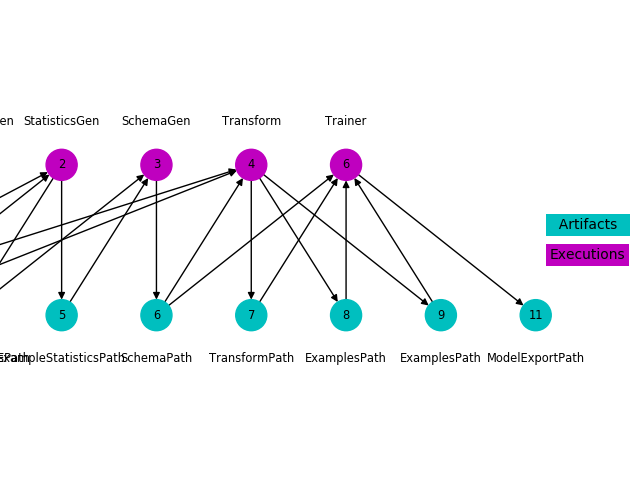

In [37]:
%matplotlib notebook
store.plot_artifact_lineage(11)